In [1]:
# =======================================
# DeepRacer Simple Log Visualization
# =======================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os.path
import glob
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString

import reward_test5 as rt

In [2]:
# --- Load CSV and track .npy file---
# replace main_dir with github repo directory
main_dir = "."
track_dir = "tracks"
eval_log_dir = os.path.join(main_dir, "eval_log/")
training_log_dir = os.path.join(main_dir, "training_log/")
#data from csv
df = pd.read_csv(os.path.join(eval_log_dir, "test5/sim-trace/evaluation/20250913073341-ZDE0VILMTfqTEKKQZMYU_A/evaluation-simtrace/0-iteration.csv"))

#track waypoints
track_file = os.path.join(main_dir, track_dir, "2024_reinvent_champ_ccw.npy")

##Parameters
#----------
#waypoints : np.ndarray
#	Array of waypoints with shape (N, 6) → [x_center, y_center, x_left, y_left, x_right, y_right]

waypoints = np.load(track_file, allow_pickle=True)

ideal_data = rt.ideal_data
center_line = ideal_data[:-1]
inner_border = waypoints[:,2:4]
outer_border = waypoints[:,4:6]
l_center_line = LineString(center_line)
l_inner_border = LineString(inner_border)
l_outer_border = LineString(outer_border)

df["speed"] = df["throttle"]  # If throttle directly maps to speed (adjust if you have actual m/s)
# If throttle is gear-like instead of real m/s, you might need: df["speed"] = df["throttle"] * speed_scale
df["episode"] = df["episode"].astype(int)
#print("Is loop/ring? ", l_center_line.is_ring)

# Visualize a DeepRacer track from an .npy file.
def plot_track(center_line, inner_border, outer_border, show_wp_index=False, show_center_line=False):
	xs, ys = center_line[:, 0], center_line[:, 1]
	left_line = inner_border
	right_line = outer_border

	# Plot
	fig, ax = plt.subplots(figsize=(20, 10))

	ax.plot(left_line[:, 0], left_line[:, 1], 'k--', label="Left Border")
	ax.plot(right_line[:, 0], right_line[:, 1], 'k--', label="Right Border")
	if show_wp_index == True:
		for i in range(0, len(center_line)):
			plt.text(xs[i] - 0.05, ys[i] + 0.1, f"{i}", fontsize=7, color="green")
	if show_center_line == True:
		ax.scatter(xs, ys, s=10, c="green", label="Waypoints")
	ax.axis("equal")
	return fig, ax

def get_distance_from_ideal_line(x, y, ideal_point_1, ideal_point_2):
	"""Calculates the distance from the ideal line defined by ideal_line."""
	vector_ideal = np.array(ideal_point_2) - np.array(ideal_point_1)
	vector_car = np.array([x, y]) - np.array(ideal_point_1)
	if np.linalg.norm(vector_ideal) < 1e-6:
		distance = np.linalg.norm(vector_car)
	else:
		dot_product = np.dot(vector_car, vector_ideal)
		parallel_point = np.array(ideal_point_1) + (dot_product / np.dot(vector_ideal, vector_ideal)) * vector_ideal
		distance = np.linalg.norm(np.array([x, y]) - parallel_point)
	return distance

In [3]:
def	get_closest_waypoints(x, y, id, ideal_line):
	neigh_ids = [(id - 1) % ideal_line.shape[0], (id + 1) % ideal_line.shape[0]]
	return sorted([id, neigh_ids[np.argmin([np.linalg.norm(ideal_line[neigh_ids[0], :] - [x, y]),
										 np.linalg.norm(ideal_line[neigh_ids[1], :] - [x, y])])]])

def add_waypoints(d, waypoints):
	d['waypoints'] = waypoints
	return d

df1 = df.rename(columns={'X': 'x', 'Y': 'y', 'throttle': 'speed', 'yaw': 'heading', 'steer': 'steering_angle'})
df1['track_width'] = 0.6
df1['is_offtrack'] = ~df1['all_wheels_on_track']
ideal_line = rt.ideal_data[:, :2]
df1['closest_waypoints'] = [get_closest_waypoints(df['X'].iloc[i], df['Y'].iloc[i], df['closest_waypoint'].iloc[i], ideal_line)
		  for i in range(df1.shape[0])]
df1['reward'] = [rt.reward_function(add_waypoints(df1.iloc[i].to_dict(), waypoints)) for i in range(df1.shape[0])]
df['reward'] = df1['reward'] 

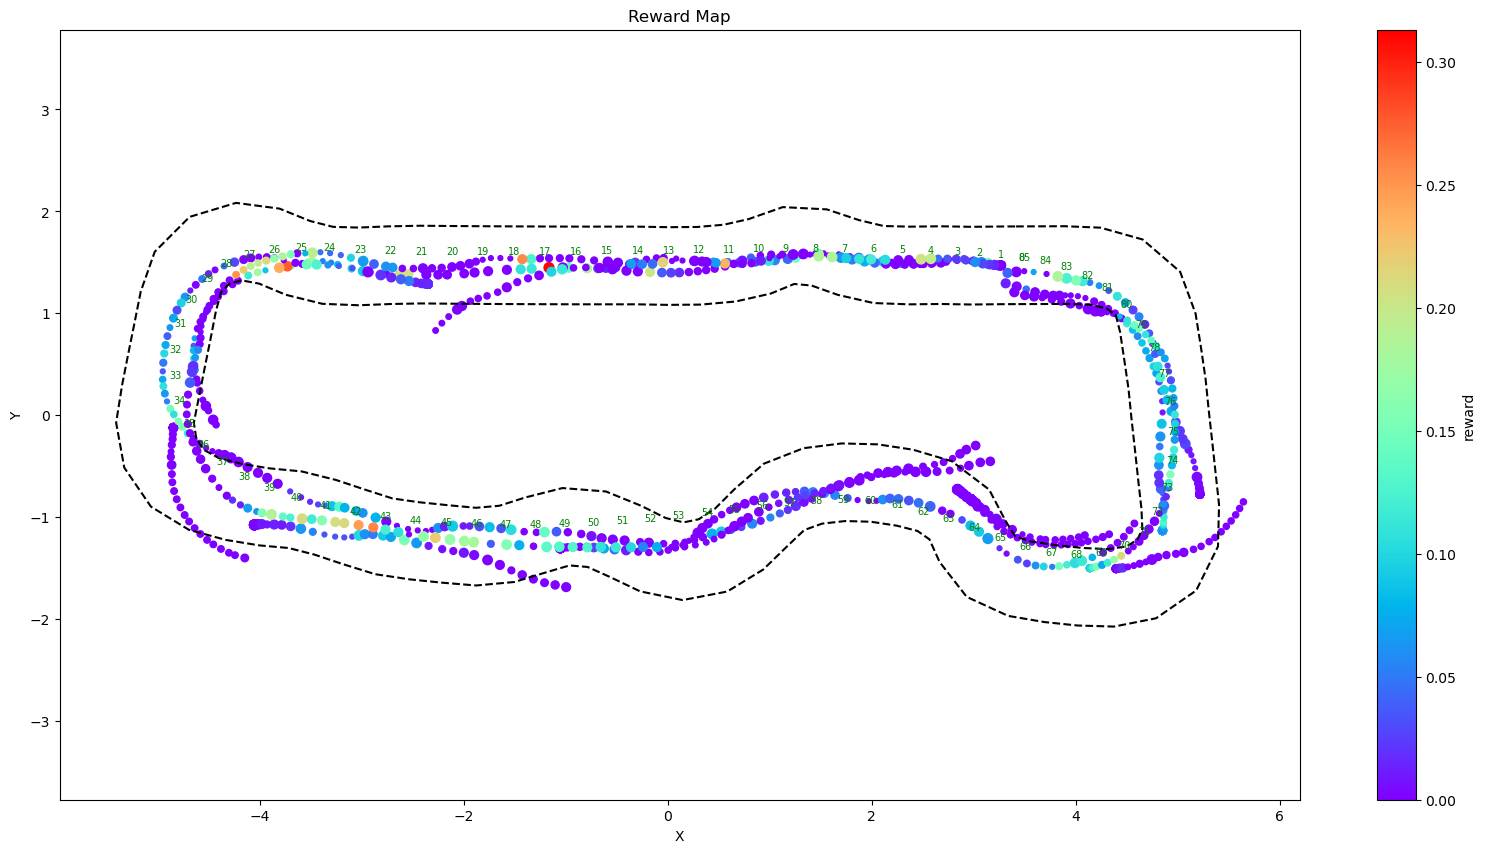

[0.6, 2.5]

In [7]:
id = 0
fig, ax = plot_track(center_line, inner_border, outer_border, True, False)
sc = ax.scatter(df["X"].loc[df['episode'] >= id], df["Y"].loc[df['episode'] >= id], c=df['reward'].loc[df['episode'] >= id], cmap="rainbow", s=20*df['throttle'].loc[df['episode'] >= id])
fig.colorbar(sc, label="reward")
plt.title("Reward Map")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()
[df['throttle'].loc[df['episode'] == id].min(), df['throttle'].loc[df['episode'] == id].max()]

In [6]:
df.head()

,episode,steps,X,Y,yaw,steer,throttle,action,reward,done,all_wheels_on_track,progress,closest_waypoint,track_len,tstamp,episode_status,pause_duration,obstacle_crash_counter,speed
0,0,1.0,3.268166,1.471205,-179.768616,-7.5,1.8,3,0.000105,False,True,0.558217,1,25.106791,4.428,prepare,0.0,0,1.8
1,0,2.0,3.268316,1.471205,-179.768483,-7.5,1.8,3,0.000053,False,True,0.557617,1,25.106791,4.500,in_progress,0.0,0,1.8
2,0,3.0,3.257873,1.468709,-179.143567,-7.5,1.8,3,0.000038,False,True,0.599316,1,25.106791,4.538,in_progress,0.0,0,1.8
3,0,4.0,3.243365,1.468944,-179.252757,-7.5,1.8,3,0.000031,False,True,0.657088,1,25.106791,4.631,in_progress,0.0,0,1.8
4,0,5.0,3.191401,1.475841,178.951544,-7.5,1.8,3,0.020213,False,True,0.863756,2,25.106791,4.697,in_progress,0.0,0,1.8
